You are given an excerpt of the log data from the [Swisslos](https://www.swisslos.ch) Jass servers collected between October 2017 and April 2018. In the Swiss card game [Jass](https://en.wikipedia.org/wiki/Jass), at the beginning of each round just after the cards have been dealt, the current player announces her choice of the trump mode from the options: diamonds, hearts, spades, club, obe-abe, une-ufe and push (only available when forehand). Use this information from human players to train a machine learning classifier in trump mode prediction.

In [2]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Import & Prepare Data

In [3]:
path_to_data = Path('data')

In [4]:
# # Import only a fraction of data for efficient testing
# data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None, nrows=1000)

# Import all data in the final run
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4


In [5]:
# Display number of rows and columns
data.shape

(359825, 39)

## Rename Columns for better Interpretability

In [6]:
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user  = ['user']
trump = ['trump']

data.columns = cards + forehand + user + trump
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CQ,CJ,C10,C9,C8,C7,C6,FH,user,trump
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4


## Remove User Information

In [7]:
Later on you may want to keep this information. For now, we remove it just to avoid mistakes.

SyntaxError: invalid syntax (<ipython-input-7-9b597b994942>, line 1)

In [8]:
# data.drop('user', axis='columns', inplace=True)
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CQ,CJ,C10,C9,C8,C7,C6,FH,user,trump
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4


## Adjust Datatypes

In [9]:
data.trump = data.trump.astype('category')
data[cards + forehand] = data[cards + forehand].astype(bool)
#data.dtypes

## Rename Target Category Values for better Interpretability

In [10]:
# Backward compatibility: Value 10 for PUSH was used in an older version by Swisslos

data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3:'CLUBS',
                                  4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'}, inplace=True)
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CQ,CJ,C10,C9,C8,C7,C6,FH,user,trump
0,False,False,False,True,True,False,True,True,False,False,...,True,False,False,False,True,False,False,False,53248,PUSH
1,False,False,False,False,False,False,False,False,True,True,...,False,True,False,False,False,True,False,False,4613,UNE_UFE
2,True,False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,True,True,False,68780,PUSH
3,False,False,False,False,False,False,False,False,False,True,...,False,False,True,True,False,False,False,False,24555,UNE_UFE
4,False,True,False,False,False,False,False,False,True,True,...,False,True,False,False,False,False,False,True,8392,OBE_ABE


# Data Quality Assessment

### Exercise: Sanity Check

Each row in the data now corresponds to one hand of a player plus her trump mode selection. Verify that each hand contains exactly 9 cards.

In [11]:
handcards=data[cards]
# Sum of result of condition "value == 1 is True"
# is calculated along the columns (axis=1) in each row
handOfPlayer=handcards[handcards == 1].sum(axis=1)
print(handOfPlayer)
handOfPlayer[handOfPlayer != 9]



0         9.0
1         9.0
2         9.0
3         9.0
4         9.0
         ... 
359820    9.0
359821    9.0
359822    9.0
359823    9.0
359824    9.0
Length: 359825, dtype: float64


Series([], dtype: float64)

### Exercise: Statistical Fingerprint

Swisslos claims to distribute cards randomly.
* Verify that all card features roughly have the same mean and standard deviation.
* Over a **large number of rounds**, we would expect similar percentages for diamonds, hearts, spades and clubs as selected Trump. Verify this claim.

Hint: you may want to use [np.allclose(...)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html) in combination with an assert statement for automated checking.

#### A note on randomness - not part of exercises: 

The above test is obviously a very poor guarantee of randomness. However, we perform such tests from the viewpoint of data quality rather than fairness. If you want to challenge the random number generator of Swisslos, use the NIST or Diehard test suite for randomness. Read more about random number tests <a href='https://gerhardt.ch/random.php'>here</a>. We have not done this ourself and keep believing that the provider of Swiss lottery use a reasonable source of randomness even for online games :-)

In [28]:
# todo
np.allclose(data['DA'].mean(),1/4,atol=0.005) 

True

In [13]:
data.trump.value_counts()

PUSH        137554
UNE_UFE      44653
SPADES       40115
CLUBS        39756
OBE_ABE      35829
HEARTS       31087
DIAMONDS     30831
Name: trump, dtype: int64

Can you explain ...
* the difference between Une-Ufe and Obe-Abe ?
* the difference between {spades, clubs} and {hearts, diamonds}

The fact that the values of the response are not distributed evenly has implications on the train-test split in the next section.

# Modelling and Prediction

### Train-Test Split

Split the available data into a training and a test set and put the test set aside for the final model evaluation. Use 20% of the data for testing, and set the random_state to 42 for reproducability. Since we found out that the classes are not distributed evenly, you need to stratify. Also, be aware that train_test_split() shuffles the data by default, which is what we want here (but not always, e.g. not in case of time series).

Your result should be the four variables *X_train, X_test, y_train, y_test*.

In [14]:
from sklearn.model_selection import train_test_split

feature_columns = cards + forehand
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data.trump, test_size=0.2,
                                                    stratify=data.trump, random_state=42)

## Baseline with a Logistic Regression Classifier

We create a (linear) logistic regression classifier and evaluate it with cross validation.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

classifier = LogisticRegression()

# Note that we do not use the test set here !
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

Mean accuracy over 5 folds is 0.6375


### Exercise: Stochastic Gradient Descent

Machine learning classifiers internally use an optimization algorithm. Stochastic gradient descent is a stochastic 
approximation that generally is more efficient but with a slightly lower convergence rate. Change the code in the previous cell to a logistic regression with stochastic gradient descent. Use [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) with parameters *loss='log'* and *penalty='None'*

In [16]:
from sklearn.linear_model import SGDClassifier


classifier = SGDClassifier(loss='log',penalty='None')

# Note that we do not use the test set here !
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))
# todo

Mean accuracy over 5 folds is 0.6409


## Learning Curves

Learning curves are an important diagnostic instrument in machine learning. A cross-validation generator splits the whole dataset k times into training and test data. Subsets of the training set with increasing sizes will be used to train the estimator and a score for each training subset size on the validation set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

As a rule of thumb, a gap between the training and validation curves indicates that using more data would improve accuracy.

In [17]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(SGDClassifier(loss='log', penalty='None'), 
                                                         X_train, y_train, n_jobs=-1,
                                                         train_sizes=np.linspace(0.1, 1.0, 50), cv=10,
                                                         exploit_incremental_learning=True, verbose=10)

[learning_curve] Training set sizes: [ 25907  30665  35424  40182  44941  49699  54458  59216  63975  68733
  73492  78250  83009  87767  92526  97284 102043 106801 111560 116318
 121077 125835 130594 135352 140111 144869 149628 154386 159145 163903
 168662 173420 178179 182937 187696 192454 197213 201971 206730 211488
 216247 221005 225764 230522 235281 240039 244798 249556 254315 259074]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:   30.3s remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   30.4s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   31.1s remaining:   31.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   31.4s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.3s finished


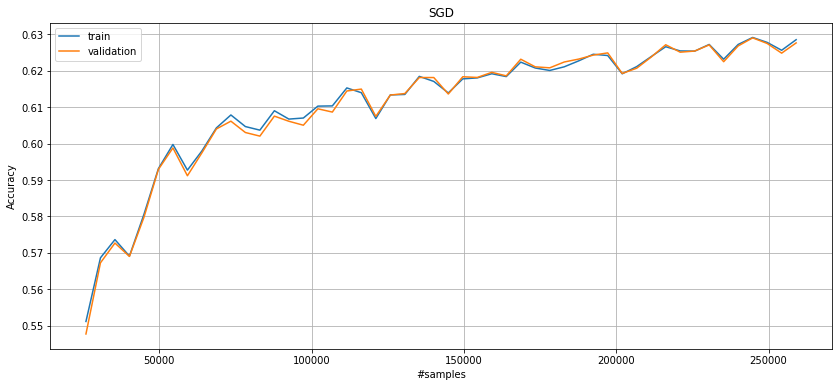

In [18]:
plot_data = pd.DataFrame({'train':train_scores.mean(axis=1), 'validation':valid_scores.mean(axis=1)}, index=train_sizes)
f, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel('#samples')
ax.set_ylabel('Accuracy')
ax.set_title('SGD')
plot_data.plot(ax=ax)
plt.grid()

### Exercise: Create a Random Forest Classifier

Now create a random forest classifier and evaluate it with cross validation.

In [19]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()

result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

# todo

Mean accuracy over 5 folds is 0.639


### Exercise: List and Plot Feature Importances

Tree classsifiers (such as decision trees and random forests) can conveniently list feature importances. They use feature values to split the training set, whereas more important features are used higher in the tree(s). Use the *feature_importances_* attribute of a trained RandomForestClassifier to obtain a sorted list of the most important features. Plot feature importances in a bar chart.

<Figure size 432x288 with 0 Axes>

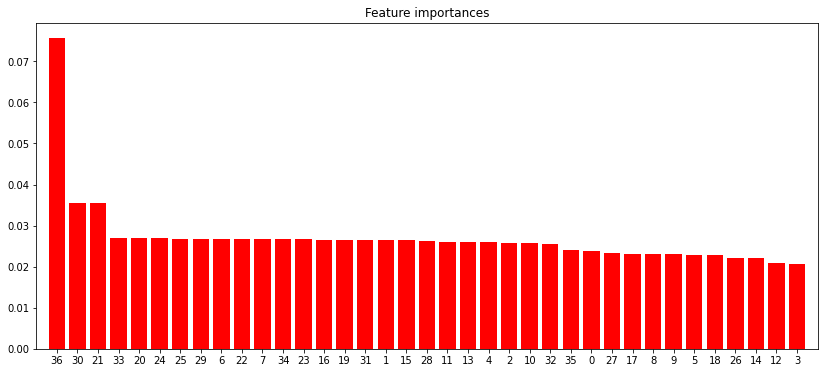

In [20]:
# todo
# create the tree
classifier.fit(X_train, y_train)
# return the importances of the features in the tree (features = columns?)
importances = classifier.feature_importances_

# returns the ranking of the importances of the features
indices = np.argsort(importances)[::-1]

plt.figure()
plt.subplots(figsize=(14, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Grid Search over multiple Classifiers and Hyperparameters

In [21]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Classifier names
names = [
    "Logistic Regression",
    "Random Forest"
]

# Classifiers
classifiers = [
    LogisticRegression(solver='lbfgs', multi_class='multinomial'), # set these to avoid a FutureWarning with scikit-lean < 0.22
    RandomForestClassifier(n_estimators=200)
]

# Hyperparameter grid to search per classifier
parameters = [
    {'C': [0.5, 1.0, 2.0]},
    {'max_depth': [5, 10]}
]

list(zip(names, parameters))
#list(zip(names,parameters)) ergibt:
# {‘Logistic Regression’, ‘C’:[0.5,1.0,2.0]}
#{‘Random Forest’,’max_depth’: [5, 10]}


[('Logistic Regression', {'C': [0.5, 1.0, 2.0]}),
 ('Random Forest', {'max_depth': [5, 10]})]

In [22]:
from sklearn.model_selection import GridSearchCV
print('gugus')
results = []

# iterate over triples
# scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
for name, classifier, params in zip(names, classifiers, parameters):
    print("Grid search for {}".format(name))
    gs = GridSearchCV(classifier, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1, verbose = 20)
    # The best Classifier-border between the to-classify-data is calculated. 
    # Due to the parameter range, there will be multiple of these functions for each Classifier
    # according to the number of parameter points with which we tune the Classifier.
    gs.fit(X_train, y_train)
    print("Best accuracy score found: {:.3f}\n".format(gs.best_score_))
    results.append([name, gs.best_score_, gs.best_estimator_,gs.best_index_])

results

gugus
Grid search for Logistic Regression
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   44.4s remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:   44.6s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   47.4s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:   47.7s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   49.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:   49.7s remaining:   56.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   51.0s remaining:   44.6s
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:   51.7s remaining:   34.4s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   57.4s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:   58.2s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapse

Best accuracy score found: 0.637

Grid search for Random Forest
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  2.0min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.0min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.6min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  2.6min remaining:   39.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.6min finished


Best accuracy score found: 0.593



[['Logistic Regression',
  0.6374800250121587,
  LogisticRegression(multi_class='multinomial'),
  1],
 ['Random Forest',
  0.5931390259153755,
  RandomForestClassifier(max_depth=10, n_estimators=200),
  1]]

Comment: If *refit=True* (the default), the best estimator is made available at the *best_estimator_* attribute of gs and permits using *.predict()* directly on this GridSearchCV instance. Note, however, that the above code runs grid search separately for each classifier, and so gs now only contains the last estimator of the list, which may or may not be the best one. So don't use gs to predict blindly.

In [23]:
from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

# Display progress logs on stdout
# logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

# Classifier names
    #"Support Vector Machines","Nearest Neighbour",
    # "KNeighbour",
names = [
    "Neuronal Network"
]

# Classifiers
    #svm.SVC(kernel='linear'),
    # KNeighborsClassifier(n_neighbors=3), 
classifiers = [
    MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1, max_iter=2000, early_stopping=True, hidden_layer_sizes=[100, 100])
]

print('hier2')

# Hyperparameter grid to search per classifier
    #{'C': [0.1, 1, 10]},
     # {'n_neighbors': [1, 2, 3]},
parameters = [
    {'alpha': [0.00001, 0.001, 0.1]}
]

print('hier3')

# list(zip(names, parameters))

results = []

# iterate over triples
# scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
for name, classifier, params in zip(names, classifiers, parameters):
    print("Grid search for {}".format(name))
    gs = GridSearchCV(classifier, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1, verbose=50)
    # The best Classifier-border between the to-classify-data is calculated. 
    # Due to the parameter range, there will be multiple of these functions for each Classifier
    # according to the number of parameter points with which we tune the Classifier.
    gs.fit(X_train, y_train)
    print("Best accuracy score found: {:.3f}\n".format(gs.best_score_))
    results.append([name, gs.best_score_, gs.best_estimator_,gs.best_index_])

results



hier2
hier3
Grid search for Neuronal Network
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed: 26.9min remaining: 175.0min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed: 26.9min remaining: 107.7min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed: 26.9min remaining: 74.1min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed: 26.9min remaining: 53.9min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 26.9min remaining: 40.4min
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed: 26.9min remaining: 30.8min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 26.9min remaining: 23.6min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed: 26.9min remaining: 18.0min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 26.9min remaining: 13.5min
[Parallel(n_jobs=-1)]: Do

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


### Exercise: Extend Grid Search by adding other Classifiers and Hyperparameters

You may want to experiment with a [nearest neighbors classifier](http://scikit-learn.org/stable/modules/neighbors.html) or a [support vector machine](http://scikit-learn.org/stable/modules/svm.html) or a [neural network](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) or ...

### Exercise: Add interactions to Logistic Regression

A linear classifier such as logistic regression cannot model dependencies between features (things like "if your hand has both heart jack and heart nine, then choose heart as trump mode"). But features like these called *interactions* can be added manually.

In [ ]:
# First, get the score without interactions
clf = LogisticRegression(C=0.8, solver='lbfgs', multi_class='multinomial')
result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

For each of the four colors, add one interaction term for the combination jack and nine.

In [ ]:
for color in 'DHSC':
    # We add a new column, which indicates, if a Jack+Nine combination exists
    # Jack and nine combination
    
    # The index name
    new_col = '{}_J9'.format(color)
    # Add the combination condition to the index
    data[new_col]  = data['{}J'.format(color)] & data['{}9'.format(color)]
    feature_columns.append(new_col)
    
    # Exercise: Add other features here such as the combination of Ace-King-Queen (Dreiblatt).
    
    # For Obe:
    # The index name
    # new_col2 = '{}_HIGH'.format(color)
    # Add the combination condition to the index
    # data[new_col2]  = data['{}A'.format(color)] & data['{}K'.format(color)] & data['{}K'.format(color)]
    # feature_columns.append(new_col2)
             
    # For Unde                                                 
    # The index name
    # new_col3 = '{}_LOW'.format(color)
    # Add the combination condition to the index
    # data[new_col]  = data['{}6'.format(color)] & data['{}7'.format(color)] & data['{}8'.format(color)]
    # feature_columns.append(new_col)                                                 
    
    
data.head()

We must recreate training and test sets with the new features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data.trump, test_size=0.2,
                                                    stratify=data.trump, random_state=42)

And check  if the additional columns improve the score

In [ ]:
clf = LogisticRegression(C=0.8, solver='lbfgs', multi_class='multinomial')
result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

### Exercise: Better Accuracy with less Data ?

At the beginning we removed the user ID from our data set. Use this information to develop a heuristic that seggregates between *good* and *bad* players. Can you improve accuracy by using only the data from *good* players?

In [ ]:
test_col = data['trump']
farbe = 'HEART'
new_col = 'good'
zeroframe = pd.DataFrame(False, index= data.index, columns=['good'], dtype = bool)
truthcolumn = pd.DataFrame(False, index= data.index, columns=['good'], dtype = bool)
# print(zeroframe)


for color in 'DHSC':
    # We add a new column, which indicates, if a Jack+Nine combination exists
    # Jack and nine combination 

    # new_col = '{}_J9_good'.format(color)
    
    if color == 'D': farbe = 'DIAMONDS'
    if color == 'H': farbe = 'HEARTS'
    if color == 'S': farbe = 'SPADES'
    if color == 'C': farbe = 'CLUBS'
    
    # data[new_col]  = data['{}J'.format(color)] & data['{}9'.format(color)] & (data['trump'] == farbe)
    truthcolumn['good'] = data['{}J'.format(color)] & data['{}9'.format(color)] & (data['trump'] == farbe) | zeroframe['good']
    zeroframe['good'] = truthcolumn['good']
    # feature_columns.append(new_col)

# print(truthcolumn['good'][0:20])


data[new_col] = truthcolumn   
feature_columns.append(new_col)    

# only the rows where the player played good
goodplayer=  data[data['good'] > 0.5] 
goodUserCount=goodplayer.user.value_counts()
# only the very best in the list are taken
bestUser=goodUserCount[1:40]
bestUser.head(3)
# the key-row contains the user-numbers
bestUser.keys()

# only rows are selected, where the players are good players
goodUserData = data[data['user'].isin(bestUser.keys())] 
goodUserData.head(10)

# the good-user-data can now be used to train
X_train, X_test, y_train, y_test = train_test_split(goodUserData[feature_columns], goodUserData.trump, test_size=0.2,
                                                    stratify=goodUserData.trump, random_state=42)

# We check now how well it works with the good-player data
classifier = LogisticRegression()

# Note that we do not use the test set here !
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

        

### Exercise: The final Score

Use the best setting you could find, train the classifier on all training data and evaluate on the yet unseen test data.

In [33]:
# Probably not the best :-)
# clf = LogisticRegression(C=0.8, solver='lbfgs', multi_class='multinomial')
# clf=RandomForestClassifier(n_estimators=200, max_depth=5)
clf=SGDClassifier(loss='log',penalty='None')
# Here I have to reestablish the X_train, y_train from the data. Since in the previous exercise I replaced the training data.
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data.trump, test_size=0.2,
                                                    stratify=data.trump, random_state=42)

result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

clf.fit(X_train, y_train)

# LogisticRegression does not converge with the test Data
clf.score(X_test, y_test)

Mean accuracy over 5 folds is 0.6407


0.6378378378378379

In [34]:
# Here we save the model for reuse
from sklearn import model_selection
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
print('saved')

saved


In [35]:
# We need to train a model without PUSH for the case that a player receives a PUSH from his partner
# Which means, that he/she will not be able to PUSH
clf=SGDClassifier(loss='log',penalty='None')
secondCategories = ['DIAMONDS','HEARTS','SPADES','CLUBS','OBE_ABE','UNE_UFE']
pushTrumpData = data[data['trump'].isin(secondCategories)] 
# print(pushTrumpData)

# the user-data without pus can now be used to train
X_trainPush, X_testPush, y_trainPush, y_testPush = train_test_split(pushTrumpData[feature_columns], pushTrumpData.trump, test_size=0.2,
                                                    stratify=pushTrumpData.trump, random_state=42)

result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

filename = 'finalized_model_pushed.sav'
pickle.dump(clf, open(filename, 'wb'))
print('saved')


Mean accuracy over 5 folds is 0.6406
saved


In [38]:
print(X_testPush)
X_trainPush.shape

           DA     DK     DQ     DJ    D10     D9     D8     D7     D6     HA  \
246993   True  False  False  False  False  False  False   True  False  False   
302172   True   True  False  False  False  False  False  False   True  False   
127988   True   True  False  False   True  False  False  False   True  False   
287109   True   True   True  False  False  False  False  False  False   True   
245334  False   True  False  False  False  False   True   True  False  False   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
269305  False   True   True  False  False  False  False  False  False   True   
238601  False  False  False  False  False  False  False  False  False  False   
241535  False  False   True  False  False  False  False  False   True   True   
194751  False  False   True  False  False  False  False  False  False   True   
267284  False   True  False   True  False   True  False  False  False  False   

        ...     CA     CK     CQ     CJ

(177816, 37)